In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from textblob import TextBlob
import nltk
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

Code below didn't work, memory errors.  Tried on EC2 with 256 GB of RAM and it wouldn't work, either.
This only seems to work on a small subset of the data; 50,000 lines at one time works so I completed the assignment with that small subset.

In [ ]:
# not run
with open('amazon-meta.txt', encoding='utf8') as f:
    content = f.readlines()

# load df with ratings
df = pd.DataFrame(columns=['Id', 'review_time', 'user_id', 'rating', 'votes_on_review', 'helpfulness'])
n = 0
current_id = 0
for line in content:
    if line.find('Id:') > -1:
        current_id = re.split('\s+', line)[1]
    if line.find('cutomer') > 0:
        insert_row = re.split("[, \\n\!?:]+", line)
        df.loc[n] = [current_id, pd.to_datetime(insert_row[1]), insert_row[3], insert_row[5], insert_row[7], insert_row[9]]
        n += 1

In [2]:
with open('amazon-meta.txt', encoding='utf8') as f:
    content = f.readlines()

In [3]:
len(content)

15010574

<strong>c2 variable will contain only the first 50,000 rows out of 15M.</strong>

In [3]:
c2 = content[0:50000]

<strong>The following for loop will extract the review information for the first 50,000 rows of the original df.</strong>

In [52]:
%%time
df = pd.DataFrame(columns=['Id', 'review_time', 'user_id', 'rating', 'votes_on_review', 'helpfulness'])
n = 0
current_id = 0
for line in c2:
    if line.find('Id:') > -1:
        current_id = re.split('\s+', line)[1]
    if line.find('cutomer') > 0:
        insert_row = re.split("[, \\n\!?:]+", line)
        df.loc[n] = [current_id, pd.to_datetime(insert_row[1]), insert_row[3], insert_row[5], insert_row[7], insert_row[9]]
        n += 1

Wall time: 5min 46s


In [51]:
df.head()

,Id,review_time,user_id,rating,votes_on_review,helpfulness,counts,mean
0,1,2000-07-28,A2JW67OY8U6HHK,5,10,9,2,5.000000
1,1,2003-12-14,A2VE83MZF98ITY,5,6,5,2,5.000000
2,2,2001-12-16,A11NCO6YTE4BTJ,5,5,4,12,4.333333
3,2,2002-01-07,A9CQ3PLRNIR83,4,5,5,12,4.333333
4,2,2002-01-24,A13SG9ACZ9O5IM,5,8,8,12,4.333333


<strong>Rating must be converted to numeric to perform calculations on it.</strong>

In [53]:
df['rating'] = df['rating'].astype(int)
df['Id'] = df['Id'].astype(int)

what can be said about the ratings quantitatively: mean and median are calculated below

In [39]:
df.rating.mean()

4.008318198329095

In [40]:
df.rating.median()

5.0

<strong>Distribution of ratings.</strong>

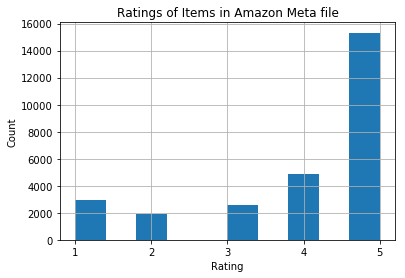

In [22]:
fig, ax = plt.subplots()
df.rating.hist()
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Ratings of Items in Amazon Meta file')
ax.set_xticks([1,2,3,4,5], minor=False)

In terms of trustworthiness, there are approaches I would try to determine if ratings were being manipulated. The date is known, so if ratings (all 5 or all 1) are being entered during a time frame that doesn't seem to align with item sales, that may be a red flag.  Also, if all of a sudden the mean rating of an item were to change significantly (for instance, item has been in the database for a long time with rating of x, then rating shifts dramatically one way or another and the number of reviews increases as well), this would be something worth investigating.

<strong>One method that could be tried would be to check to see when a large percentage of all reviews were made in a single day if the average of these reviews is more than 1.0 different than all reviews.  Only look at items with a minimum of 50 reviews.</strong>

In [54]:
df['counts'] = df.groupby(['Id'])['Id'].transform('count')
df['mean_rating'] = df.groupby(['Id'])['rating'].transform('mean')

In [55]:
df.head()

,Id,review_time,user_id,rating,votes_on_review,helpfulness,counts,mean_rating
0,1,2000-07-28,A2JW67OY8U6HHK,5,10,9,2,5.000000
1,1,2003-12-14,A2VE83MZF98ITY,5,6,5,2,5.000000
2,2,2001-12-16,A11NCO6YTE4BTJ,5,5,4,12,4.333333
3,2,2002-01-07,A9CQ3PLRNIR83,4,5,5,12,4.333333
4,2,2002-01-24,A13SG9ACZ9O5IM,5,8,8,12,4.333333


In [39]:
len(df)

27530

In [56]:
df50 = df.drop(df[df.counts < 50].index)

In [57]:
df50.head()

,Id,review_time,user_id,rating,votes_on_review,helpfulness,counts,mean_rating
115,21,1998-12-27,A3D0FUIHSMCHXG,5,1,1,140,4.564286
116,21,1998-12-28,A106FE8HPE6LK6,4,9,9,140,4.564286
117,21,1999-04-19,A1Y6LC4JFBCGZN,4,6,6,140,4.564286
118,21,1999-05-11,A2A1EHOGR8MW0I,5,1,1,140,4.564286
119,21,1999-06-09,A3I7CRNHGZVWXP,5,2,2,140,4.564286


In [62]:
len(df50)

18565

In [58]:
df50 = df50.drop('counts', 1)

In [59]:
df50.review_time = pd.to_datetime(df50.review_time)
df50.rating = pd.to_numeric(df50.rating)
df50.votes_on_review = pd.to_numeric(df50.votes_on_review)
df50.helpfulness = pd.to_numeric(df50.helpfulness)

In [60]:
df50 = df50.reset_index(drop=True)

In [61]:
df50.head()

,Id,review_time,user_id,rating,votes_on_review,helpfulness,mean_rating
0,21,1998-12-27,A3D0FUIHSMCHXG,5,1,1,4.564286
1,21,1998-12-28,A106FE8HPE6LK6,4,9,9,4.564286
2,21,1999-04-19,A1Y6LC4JFBCGZN,4,6,6,4.564286
3,21,1999-05-11,A2A1EHOGR8MW0I,5,1,1,4.564286
4,21,1999-06-09,A3I7CRNHGZVWXP,5,2,2,4.564286


In [62]:
df_byDate = df50.set_index('review_time')

In [63]:
df_50_2 = df_byDate.groupby(by=['Id','review_time','mean_rating'], as_index=False)['rating'].agg(['mean', 'count'])

In [64]:
df_50_2.head()

mean  count
Id review_time mean_rating             
21 1998-12-27  4.564286      5.0      1
   1998-12-28  4.564286      4.0      1
   1999-04-19  4.564286      4.0      1
   1999-05-11  4.564286      5.0      1
   1999-06-09  4.564286      5.0      1

In [65]:
df_50_2 = df_50_2.reset_index()

In [66]:
df_50_2.head()

,Id,review_time,mean_rating,mean,count
0,21,1998-12-27,4.564286,5.0,1
1,21,1998-12-28,4.564286,4.0,1
2,21,1999-04-19,4.564286,4.0,1
3,21,1999-05-11,4.564286,5.0,1
4,21,1999-06-09,4.564286,5.0,1


In [71]:
df_50_2['abs_diff_rating'] = abs(df_50_2['mean_rating'] - df_50_2['mean'])

In [72]:
df_50_2.head()

,Id,review_time,mean_rating,mean,count,abs_diff_rating
0,21,1998-12-27,4.564286,5.0,1,0.435714
1,21,1998-12-28,4.564286,4.0,1,0.564286
2,21,1999-04-19,4.564286,4.0,1,0.564286
3,21,1999-05-11,4.564286,5.0,1,0.435714
4,21,1999-06-09,4.564286,5.0,1,0.435714


In [80]:
df_50_2_large_diff = df_50_2[(df_50_2['count'] > 10) & (df_50_2.abs_diff_rating > 1)]

In [81]:
len(df_50_2_large_diff)

5

<strong>The cell below shows the five rows of IDs I would be most suspicious of, in terms of rating manipulation, particularly ID 1212 where the mean rating for this item is 4.17, however on 10/12/1998 there were 40 reviews for this item with mean of 2.95.</strong>

In [82]:
df_50_2_large_diff

,Id,review_time,mean_rating,mean,count,abs_diff_rating
6014,688,1999-02-24,2.777251,1.363636,11,1.413615
1442,296,2004-01-13,3.492293,2.230769,13,1.261523
9829,1212,1998-10-12,4.167910,2.950000,40,1.217910
1512,296,2004-03-23,3.492293,2.307692,13,1.184600
1428,296,2003-12-30,3.492293,2.444444,18,1.047848


In [85]:
%%time

# this resulted in a dead kernel when I used the entire content variable
# tried again with 250,000 records in c3 variable

c3 = content[0:250000]
bookcat = pd.DataFrame(columns=['Id', 'category'])
n = 0
for line in c3:
    if line.find('Id:') > -1:
        current_id = re.split('\s+', line)[1]
    if line.find('|Books') > 0:
        bookcat.loc[n] = [current_id, line.strip()]
        n += 1

Wall time: 1min 39s


In [5]:
len(bookcat)

20543

In [7]:
bookcat.head()

,Id,category
0,1,|Books[283155]|Subjects[1000]|Religion & Spiri...
1,1,|Books[283155]|Subjects[1000]|Religion & Spiri...
2,2,|Books[283155]|Subjects[1000]|Religion & Spiri...
3,2,|Books[283155]|Subjects[1000]|Religion & Spiri...
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48...


category bloat
there seem to be pros and cons to this; on the one hand, the "bloat" might be useful for people who have different browsing habits.  I know I personally often browse categories and would not think to look in some categories at all if they were worded differently in any event, redundancy can be quantified.  Just from looking through the list, things like the following are redundant:

|Books[283155]|Subjects[1000]|Children's Books[4]|Series[3302]|Mystery & Detective[3360]|Scooby-Doo Mystery[281836]<br />
|Books[283155]|Subjects[1000]|Children's Books[4]|Series[3302]|Mystery & Detective[3360]|Scooby Doo Mysteries[918102]<br />

maybe one book has just one mystery in it, and the other has multiple mysteries, but this doesn't seem necessary to me. Another:

|Books[283155]|Subjects[1000]|Children's Books[4]|History & Historical Fiction[2917]|Exploration & Discovery[2925]<br />
|Books[283155]|Subjects[1000]|Children's Books[4]|History & Historical Fiction[2917]|Fiction[2926]|Exploration & Discoveries[2930]<br />

the additional category of "Fiction[2926]" seems redundant how to quantify - I would suggest first looking at different categories and comparing how similar the text strings are this could be done by striping out the "[", "]" and numeric characters, finding most similar and sorting for the second redundancy, I would try the same approach of striping out the special chars / numerics, then looking for repeating words.

example of first approach below

In [86]:
# df.location.str.strip('()')
bookcat.category = bookcat.category.replace('\[|\]', '', regex=True)
bookcat.category = bookcat.category.replace('[0-9]', '', regex=True)

In [7]:
pd.set_option('display.max_colwidth', -1)
bookcat.head()

,Id,category
0,2741,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Chemical Engineering|Instrumentation and Controls
1,3721,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Civil Engineering|Hydraulic Engineering
2,3324,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Circuits
3,3324,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Electronic Packaging
4,5678,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Engineering Calculations


In [66]:
# sort by category, then use library called fuzzywuzzy to rank the string above or below the current row
bookcat = bookcat.drop_duplicates(subset='category')
bookcat = bookcat.sort_values('category')
bookcat = bookcat.reset_index(drop=True)

In [30]:
bookcat['catabove'] = bookcat.category.shift(1)
bookcat['catbelow'] = bookcat.category.shift(-1)
bookcat['above'] = 0
bookcat['below'] = 0

In [31]:
bookcat.head()

,Id,category,catabove,catbelow,above,below
0,2741,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Chemical Engineering|Instrumentation and Controls,NaN,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Civil Engineering|Hydraulic Engineering,0,0
1,3721,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Civil Engineering|Hydraulic Engineering,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Chemical Engineering|Instrumentation and Controls,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Circuits,0,0
2,3324,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Circuits,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Civil Engineering|Hydraulic Engineering,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Electronic Packaging,0,0
3,3324,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Electronic Packaging,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Circuits,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Engineering Calculations,0,0
4,5678,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Engineering Calculations,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Electrical Engineering|Electronic Packaging,"|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Mechanical Engineering|Fans, Pumps and Compressors",0,0


In [29]:
bookcat.tail()

,Id,category,catabove,catbelow,above
4267,7646,"||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Blue's Clues Videos","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Barney Videos","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|DVDs for Babies and Toddlers",0
4268,6459,"||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|DVDs for Babies and Toddlers","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Blue's Clues Videos","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Sesame Street Videos",0
4269,2932,"||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Sesame Street Videos","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|DVDs for Babies and Toddlers","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|The Wiggles DVDs",0
4270,8334,"||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|The Wiggles DVDs","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Sesame Street Videos","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Videos for Babies and Toddlers",0
4271,1016,"||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Videos for Babies and Toddlers","||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|The Wiggles DVDs",NaN,0


In [32]:
# eliminate NaN values
bookcat.catabove[0] = bookcat.category[0]
bookcat.catbelow[4271] = bookcat.category[4271]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [35]:
%%time

for index, row in bookcat.iterrows():
    bookcat.above[index] = fuzz.ratio(bookcat.category[index], bookcat.catabove[index])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Wall time: 1h 28min 26s


because the above code took nearly 1 1/2 hours to run, I did not run the following which would have evaluated the category string below the current row

In [39]:
# show only the top matches
bookcat[bookcat.above >= 95]

,Id,category,catabove,catbelow,above,below
0,2741,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Chemical Engineering|Instrumentation and Controls,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Chemical Engineering|Instrumentation and Controls,|Books|By Publisher|McGraw-Hill|McGraw-Hill Engineering Store|Civil Engineering|Hydraulic Engineering,100,0
123,3749,|Books|Formats|Books on Tape|Religion & Spirituality|Christianity|Bibles,|Books|Formats|Books on Tape|Religion & Spirituality|Christianity,|Books|Formats|Books on Tape|Religion & Spirituality|Ethics,95,0
150,61,|Books|Formats|Libros en español|Infantil y juvenil|Bebes a años,|Books|Formats|Libros en español|Infantil y juvenil| a años,|Books|Formats|Libros en español|Infantil y juvenil|No ficción,96,0
206,3391,|Books|Specialty Stores|New & Used Textbooks|Business & Finance|Economics|Microeconomics,|Books|Specialty Stores|New & Used Textbooks|Business & Finance|Economics|Macroeconomics,|Books|Specialty Stores|New & Used Textbooks|Business & Finance|Ethics,99,0
264,5407,|Books|Specialty Stores|New & Used Textbooks|Sciences|Biological Sciences|Zoology,|Books|Specialty Stores|New & Used Textbooks|Sciences|Biological Sciences|Ecology,|Books|Specialty Stores|New & Used Textbooks|Sciences|Chemistry|General,98,0
271,2508,|Books|Specialty Stores|New & Used Textbooks|Sciences|Mathematics|Geometry,|Books|Specialty Stores|New & Used Textbooks|Sciences|Mathematics|General,|Books|Specialty Stores|New & Used Textbooks|Sciences|Mathematics|Statistics,95,0
292,6223,|Books|Specialty Stores|New & Used Textbooks|Social Sciences|Sociology|Theory,|Books|Specialty Stores|New & Used Textbooks|Social Sciences|Sociology|Gender,|Books|Specialty Stores|New & Used Textbooks|Social Sciences|Women's Studies,95,0
332,247,"|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Modern","|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Medieval","|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Realism",95,0
334,3553,"|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Renaissance","|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Realism","|Books|Subjects|Arts & Photography|Art|Art History|Schools, Periods & Styles|Rococo",95,0
342,3444,|Books|Subjects|Arts & Photography|Art|Instruction & Reference|Figure Drawing,|Books|Subjects|Arts & Photography|Art|Instruction & Reference|Drawing,|Books|Subjects|Arts & Photography|Art|Instruction & Reference|General,95,0


just by scrolling through the list, you can see some categories that could be eliminated, but you can also see how the "fuzz.ratio" will detect high similarity in categories that are different, but not that different gramatically such as, Microeconomics and Macroeconomics, Zoology and Ecology, Ballroom and Ballet, Asia and Africa, etc.

however, from the list above, the following categories could be targeted for consolidation:

|Books|Subjects|Arts & Photography|Art|Instruction & Reference|Figure Drawing<br />
|Books|Subjects|Arts & Photography|Art|Instruction & Reference|Drawing<br />
(depending how many 'figure drawing' vs. 'drawing' books there are)<br />

|Books|Subjects|Business & Investing|Management & Leadership|Management Science<br />
|Books|Subjects|Business & Investing|Management & Leadership|Management<br />

|Books|Subjects|Religion & Spirituality|Spirituality|Prayerbooks<br />
|Books|Subjects|Religion & Spirituality|Spirituality|Prayer<br />

|Books|Subjects|Romance|Authors, A-Z|( M )|Macomber, Debbie<br />
|Books|Subjects|Romance|Authors, A-Z|( M )|MacOmber, Debbie<br />
(these probably are the same, depending on if case matters)<br />

|Books|Subjects|Science Fiction & Fantasy|Authors, A-Z|( A )|Asprin, Robert Lynn<br />
|Books|Subjects|Science Fiction & Fantasy|Authors, A-Z|( A )|Asprin, Robert<br />
(would need to determine if one name can be used for one author, either one category for "Robert Lynn" or "Robert")<br />

||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Barney Videos<br />
||Specialty Stores|Books, Music & More|Videos and DVDs for Babies and Toddlers|Barney DVDs<br />
(depends on how many Barney videos vs. DVDs there are but these may be able to be grouped)<br />

it does not seem possible to me to reduce the number of categories drastically (to 10% of current) by sacrificing few categories (such as 10%).  The only thing I could think to do is: take every book that is not in a "general" category and keep these categories, then take all the books that are in a general category and eliminate all the other categories these books are in.  Even if every book was placed only in a "general" category, this would lead to 663 categories from starting with 4,295...so not a reduction to 10% of existing, but a large decrease.

In [13]:
bookcat_orig = bookcat

In [14]:
bookcat_orig.head()

,Id,category
0,1,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]
1,1,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]
2,2,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484]
3,2,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486]
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144]


In [15]:
len(bookcat_orig)

20543

In [16]:
# with duplicate categories removed:
bookcat_orig_nodup = bookcat_orig.drop_duplicates(subset='category')

In [17]:
len(bookcat_orig_nodup)

4295

In [35]:
bookcat_orig['inGeneral'] = bookcat_orig.category.str.contains('General')

In [36]:
bookcat_orig.head()

,Id,category,inGeneral
0,1,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368],False
1,1,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370],False
2,2,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484],False
3,2,|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486],False
4,3,|Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144],True


In [65]:
# separate the general categories, count without duplicates to see how many general categories there are
bookcat_ids_to_keep = bookcat[bookcat.inGeneral == True]
temp = bookcat_ids_to_keep.drop_duplicates(subset='category')
len(temp)

663

In [67]:
# the following combines all general categories and all books not in a general category
# remove duplicates and count; this seems like an easy way to trim down on categorizations without re-categorizing anything
bookcat_necessary_categories = bookcat[(bookcat.inGeneral == True) | (~bookcat.Id.isin(bookcat_ids_to_keep.Id))]
bookcat_necessary_categories = bookcat_necessary_categories.drop_duplicates(subset='category')
len(bookcat_necessary_categories)

1868

<strong>Another text analysis technique to group similar categories would be to stem the words and combine categories into the stemmed version.  This would involve finding the stem of the last work in the category and seeing if any of these words could be combined.</strong>

In [96]:
pd.set_option('display.max_colwidth', -1)
bookcat2 = bookcat.copy()

In [101]:
#df['AB'].str.split(' ', 1, expand=True)
bookcat2['category2'] = bookcat2['category'].str.split('|')
bookcat2.head()

,Id,category,category2
0,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Preaching,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]"
1,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Sermons,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]"
2,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Wicca,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]"
3,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Witchcraft,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]"
4,3,|Books|Subjects|Home & Garden|Crafts & Hobbies|General,"[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]"


In [107]:
bookcat2['final_category'] = bookcat2['category2'].str[-1]

In [108]:
bookcat2.head()

,Id,category,category2,final_category
0,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Preaching,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]",Preaching
1,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Sermons,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]",Sermons
2,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Wicca,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]",Wicca
3,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Witchcraft,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]",Witchcraft
4,3,|Books|Subjects|Home & Garden|Crafts & Hobbies|General,"[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]",General


In [110]:
# unique final categories
bookcat2.final_category.nunique()

2629

In [113]:
stemmer = SnowballStemmer("english")

In [116]:
stemmer.stem("Preaching")

'preach'

In [118]:
bookcat3 = bookcat2.copy()

In [132]:
bookcat3['stemmed'] = bookcat3['final_category'].apply(lambda x : stemmer.stem(x.lower()))

In [133]:
bookcat3.head()

,Id,category,category2,final_category,stemmed
0,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Preaching,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]",Preaching,preach
1,1,|Books|Subjects|Religion & Spirituality|Christianity|Clergy|Sermons,"[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]",Sermons,sermon
2,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Wicca,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]",Wicca,wicca
3,2,|Books|Subjects|Religion & Spirituality|Earth-Based Religions|Witchcraft,"[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]",Witchcraft,witchcraft
4,3,|Books|Subjects|Home & Garden|Crafts & Hobbies|General,"[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]",General,general


In [134]:
bookcat3.stemmed.nunique()

2583

<strong>The above process cuts down on the categories from 2629 to 2583, which is a start towards trimming down on categories.</strong>

How would you build the product categorization from scratch, using similar/co-purchased information?
I would try methods utilizing similarity scores (such as cosine and Jaccard similarity) between items.
also, finding an item that most represents a category, then seeing which items were purchased with those items (K nearest neighbors) is another approach.  One caveat of using "people who bought also bought" only would be candles and matches or something similar - items that may often be purchased together, but are not necessarily of the same category.

Is it a good idea to show users the categorization hierarchy for items?
Upside: users can easily "back out" one level to see items that may be more general, if they are starting out too specific.  This is a nice feature to have available.
Downside: users could get easily distracted with too many categories, or overwhelmed by choices.
My opinion: the pros outweigh the cons, but it would be worthwhile to view browsing history to see what people are clicking on and if those clicks are leading to buys or bounces.

Is it a good idea to show users similar/co-purchased items?
Upside: more choices, downside: users could be overwhelmed, get sidetracked, or end up buying less (or cheaper) products in the long run.  Overall, I think it's worth it, but it does add a level of complexity to purchases and for users who just want to make a quick purchase and move on to other things, it could be overkill or end up making users who don't want to spend a lot of time on the site go elsewhere to use a more pared-down e-commerce website.

Is it a good idea to show users reviews and ratings for items?
I definitely think it is, although integrating reviews/ratings may have a short-term impact of lower sales.  For example, user comes to buy an item, sees poor reviews, searches elsewhere on the site, can't find an item that meets their standard of quality, and leaves.  Without reviews/ratings, they probably would have made a purchase - negative reviews "talked them out of it".  However, in the long run, this makes users more educated, and this may (should?) lead to users returning to the site, even if they didn't buy the last time they were there.